# Nose for dog 12

# Concept Relevance Propagation


In [1]:
# pip install pytest

### 1. Introduction: Behind The Scenes

The CRP toolbox builds on [zennit](https://github.com/chr5tphr/zennit). It takes advantage of PyTorch’s autograd module to compute gradients in computational graphs.
zennit modifies the backpropagated gradient in such a way that they are replaced by attributions. The library is highly customizable with a focus on [LRP](http://www.heatmapping.org/) (Layer-wise Relevance Propagation), while other popular techniques like [Integrated Gradient](https://arxiv.org/abs/1703.01365) are also available. Please refer to the well written [zennit documentation](https://zennit.readthedocs.io/en/latest/) before you continue.

**Don't worry**, to use CRP you don't need to understand how this toolbox works exactly. However, for the interested reader, we'll briefly elaborate on it:

<img src="images/exclude_parallel.svg"  width="1000" style="background-color:white;">

In a backward pass, PyTorch would usually pass the gradients from all neurons of a higher layer to the lower layers and mix them up, however CRP works by passing only specific parts of the gradients and zeroing out the others. Zennit replaces these gradients with actual attribution scores that flow from the last layer to the first one.

In the Image **a)** you see, that we only pass the attributions of the neuron '0' in layer 'layer3' to the next layers. And then again pass only the attributions of neuron '0' and '2' in layer 'layer1' to the input.
If we were to implement this with a normal PyTorch [backward hook](https://pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_full_backward_hook.html) in layer 'layer1', we would write the following code that sets the input gradient to zero everywhere except for the neurons '0' and '2':

In [52]:
import torch

import sys
import os

In [53]:
from crp.concepts import ChannelConcept

cc = ChannelConcept()

### 2. Computing Conditional Heatmaps

In [54]:
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


c:\Users\praba\anaconda3\envs\internship_2\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\praba\anaconda3\envs\internship_2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


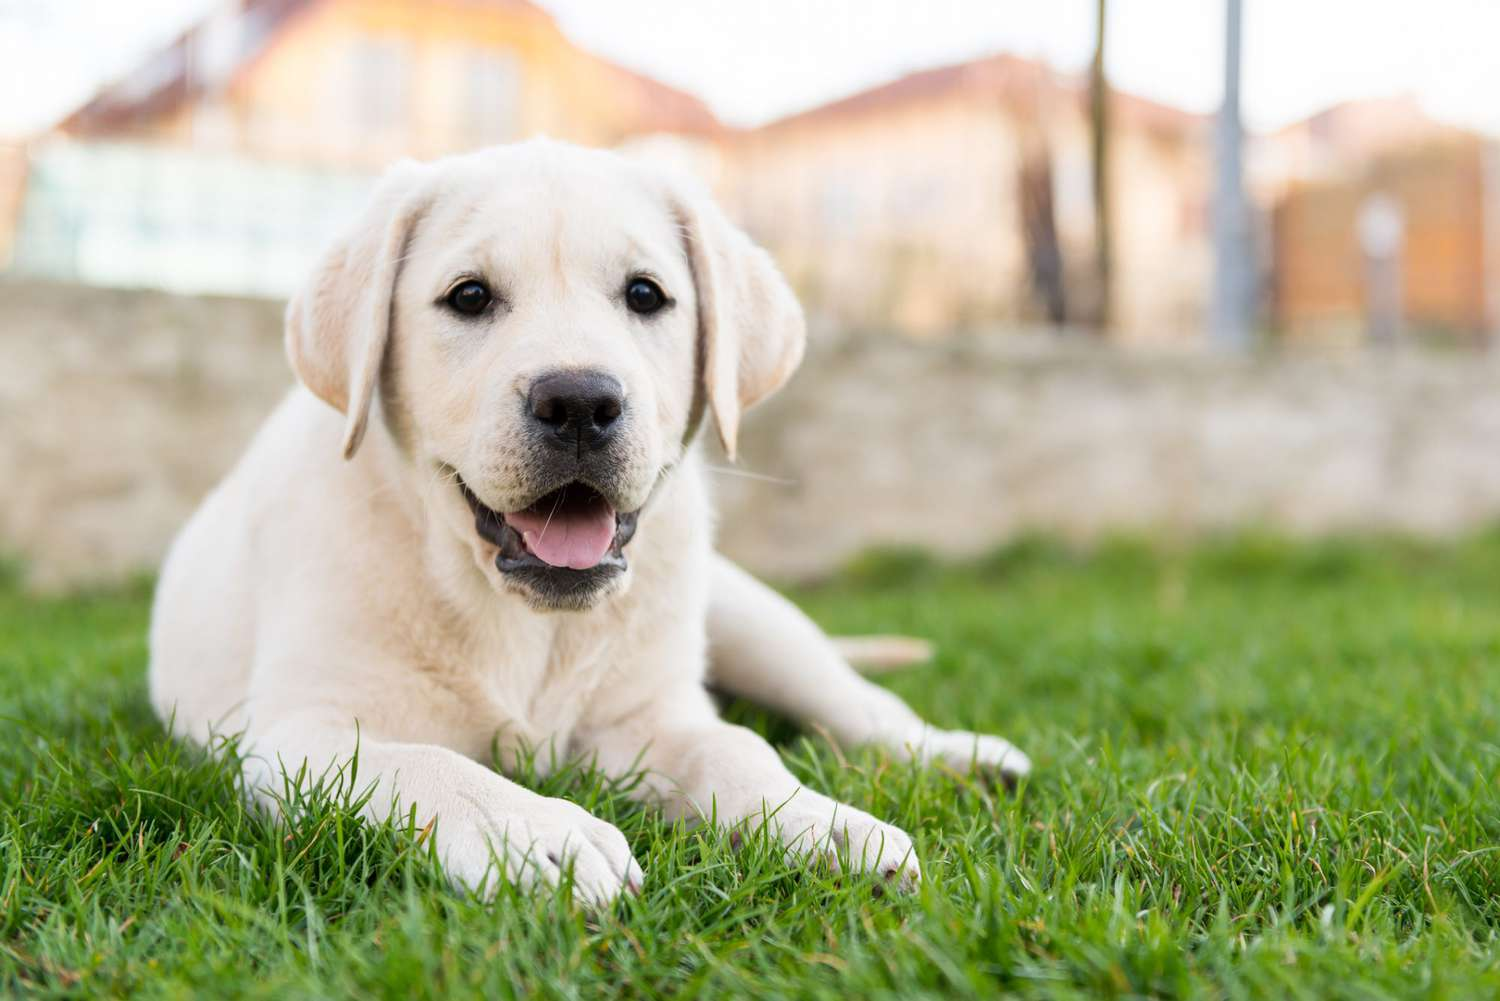

In [55]:
image = Image.open("images/dog12.jpg")

sample = transform(image).unsqueeze(0).to(device)

image

In [56]:
# transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# image_l1 = Image.open("images/lizard.jpg")
# image_d1 = Image.open("images/dog1.jpg")

# sample_l1 = transform(image_l1).unsqueeze(0).to(device)
# sample_d1 = transform(image_d1).unsqueeze(0).to(device)




In [57]:
from zennit.composites import EpsilonPlusFlat   #  computes LRP relevance
from zennit.canonizers import SequentialMergeBatchNorm   # Canonizer to merge the parameters of all batch norms that appear sequentially right after a linear module.

from crp.attribution import CondAttribution  # This class contains the functionality to compute conditional attributions.

composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])  # The EpsilonPlusFlat composite will be used with a SequentialMergeBatchNorm to handle batch normalization layers.
attribution = CondAttribution(model, no_param_grad=True)   # CondAttribution(model, no_param_grad=True) creates an attribution object for model without calculating gradients with respect to its parameters.

In [58]:
sample.requires_grad = True

In [59]:
# from crp.image import imgify

# conditions = [{"y": [208], "features.40": [117]}]

# heatmap, _, _, _ = attribution(sample, conditions, composite)

# imgify(heatmap, symmetric=True)

In [60]:
# conditions = [{"y": [208], "features.40": [1]}]

# heatmap, _, _, _ = attribution(sample, conditions, composite)

# imgify(heatmap, symmetric=True)

### Recording and Attributing Latent Concept Relevances

In order for us to know which concepts are most decisive for a prediction, we need to record the relevances of the intermediate layers. For this, we can pass a list of layer names to the `record_layer` parameter. For convenience, we use the `get_layer_names` function that returns the name of all layers of a specific type.

## Layer -40

In [61]:
from crp.helper import get_layer_names
from crp.attribution import CondAttribution
from crp.image import imgify

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

conditions = [{'y': [208]}]

attr = attribution(sample, conditions, composite, record_layer=layer_names)

attr.activations['features.40'].shape, attr.relevances['features.40'].shape

(torch.Size([1, 512, 14, 14]), torch.Size([1, 512, 14, 14]))

In [62]:
# attr.relevances["features.40"].shape

The `attribute` method of the `ChannelConcept` class assigns relevance to each concept. The first element corresponds to the first channel and so on. The `abs_norm` flag normalizes relevance by dividing by the sum of absolute value.

In [63]:
# layer features.40 has 512 channel concepts
rel_c = cc.attribute(attr.relevances['features.40'], abs_norm=True)
rel_c.shape

torch.Size([1, 512])

In [64]:
# the six most relevant concepts and their contribution to final classification in percent
rel_values, concept_ids = torch.topk(rel_c[0], 20)
concept_ids, rel_values*100

(tensor([327, 117, 282,  71, 484, 438, 195,  19, 415, 454, 196, 476,  53, 385,
          60, 323, 400, 264, 348,  62]),
 tensor([6.6990, 2.9147, 2.6250, 2.4001, 2.3236, 1.8738, 1.5455, 1.5257, 1.4723,
         1.4063, 1.3393, 1.3388, 1.2823, 1.2731, 1.2165, 1.0898, 0.9687, 0.9373,
         0.9346, 0.8890]))

Let's look at their conditional heatmaps!

In [65]:
concept_ids

tensor([327, 117, 282,  71, 484, 438, 195,  19, 415, 454, 196, 476,  53, 385,
         60, 323, 400, 264, 348,  62])

In [66]:
if type(concept_ids) != list : 
    concept_ids = concept_ids.tolist()
concept_ids

[327,
 117,
 282,
 71,
 484,
 438,
 195,
 19,
 415,
 454,
 196,
 476,
 53,
 385,
 60,
 323,
 400,
 264,
 348,
 62]

In [67]:
heatmap_s=[]
for i in concept_ids:
    conditions = [{'features.40': [i], 'y': [208]}]
    heatmap, _, _, _ = attribution(sample, conditions, composite)
    heatmap_s.append(heatmap)
    




In [68]:
from crp.image import imgify
import numpy as np
from PIL import Image


# Convert the list of heatmaps to images without text
heatmap_images = []
for heatmap in heatmap_s:
    img = imgify(heatmap, symmetric=True)  
    heatmap_images.append(img)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    #  images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
grid_size = (4, 5)  # (rows, columns)
final_image = create_image_grid(heatmap_images, grid_size)

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"  # Update this to your desired directory
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_40.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [69]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os


# List to store the heatmaps
heatmap_s = []

# Iterate over feature_40_5 and rel_c to compute the heatmaps
for i in concept_ids:
    conditions = [{'features.40': [i], 'y': [208]}]
    print(conditions)
    heatmap, _, _, _ = attribution(sample, conditions, composite)
    
    # Convert heatmap to numpy array if it's not already in a compatible format
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.detach().cpu().numpy()
    elif not isinstance(heatmap, np.ndarray):
        raise TypeError("Heatmap should be a torch.Tensor or np.ndarray")

    heatmap_s.append((heatmap, f"f.40-> C.{i}"))

# Define a function to add text below an image
def add_text_below_image(image, text, font_size=20, color=(0, 0, 0)):
    # Create a new image with space for the text below
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    new_img_height = image.height + text_height + 10  # 10 pixels padding
    new_image = Image.new("RGB", (image.width, new_img_height), (255, 255, 255))
    new_image.paste(image, (0, 0))
    
    text_position = ((image.width - text_width) // 2, image.height + 5)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, text, font=font, fill=color)
    
    return new_image

# Convert the list of heatmaps to images with text below
heatmap_images = []
for heatmap, text in heatmap_s:
    img = imgify(heatmap, symmetric=True)  # imgify should return a PIL image
    img_with_text = add_text_below_image(img, text)
    heatmap_images.append(img_with_text)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    #  images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
grid_size = (4,5)  # (rows, columns)
final_image = create_image_grid(heatmap_images, grid_size)

# Save the image as a JPG file
save_directory = "C:/Users/praba/Desktop/z_img"  #
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_40_text.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [327], 'y': [208]}]
[{'features.40': [117], 'y': [208]}]
[{'features.40': [282], 'y': [208]}]
[{'features.40': [71], 'y': [208]}]
[{'features.40': [484], 'y': [208]}]
[{'features.40': [438], 'y': [208]}]
[{'features.40': [195], 'y': [208]}]
[{'features.40': [19], 'y': [208]}]
[{'features.40': [415], 'y': [208]}]
[{'features.40': [454], 'y': [208]}]
[{'features.40': [196], 'y': [208]}]
[{'features.40': [476], 'y': [208]}]
[{'features.40': [53], 'y': [208]}]
[{'features.40': [385], 'y': [208]}]
[{'features.40': [60], 'y': [208]}]
[{'features.40': [323], 'y': [208]}]
[{'features.40': [400], 'y': [208]}]
[{'features.40': [264], 'y': [208]}]
[{'features.40': [348], 'y': [208]}]
[{'features.40': [62], 'y': [208]}]


In [71]:
print(concept_ids)

[327, 117, 282, 71, 484, 438, 195, 19, 415, 454, 196, 476, 53, 385, 60, 323, 400, 264, 348, 62]


## Layer -37

In [72]:

# conditions = [{'features.40': [id], 'y': [46]} for id in [327,  71, 476, 117, 282, 323]]

feature_40_5=concept_ids
rel_c = []
for id in feature_40_5 :
    conditions = [{'features.40': [id], 'y': [208]}]
    attr = attribution(sample, conditions, composite, record_layer=["features.37"])
    rel_c_channel = cc.attribute(attr.relevances["features.37"], abs_norm=True)
    
    rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])


In [73]:
for i in range(len(feature_40_5)):
    print("feature_40-----> channel: ",feature_40_5[i],"        feature_37 --------> top 5 relevances channel: ",rel_c[i] )

feature_40-----> channel:  327         feature_37 --------> top 5 relevances channel:  tensor([203,  64, 394,  78, 476])
feature_40-----> channel:  117         feature_37 --------> top 5 relevances channel:  tensor([  5, 394,  75, 227,  64])
feature_40-----> channel:  282         feature_37 --------> top 5 relevances channel:  tensor([279, 400, 314,  74, 189])
feature_40-----> channel:  71         feature_37 --------> top 5 relevances channel:  tensor([349, 362,  53,  13, 249])
feature_40-----> channel:  484         feature_37 --------> top 5 relevances channel:  tensor([ 64, 375, 212, 303,   8])
feature_40-----> channel:  438         feature_37 --------> top 5 relevances channel:  tensor([465,  52, 362, 417, 455])
feature_40-----> channel:  195         feature_37 --------> top 5 relevances channel:  tensor([ 50, 403,  64, 507, 150])
feature_40-----> channel:  19         feature_37 --------> top 5 relevances channel:  tensor([ 64, 375, 428, 400, 275])
feature_40-----> channel:  415    

In [74]:
rel_c[3][0]


tensor(349)

In [75]:
# rel_c[5][0][0]

In [76]:
for i in range(len(feature_40_5)):
    print("feature_40-----> channel: ",feature_40_5[i],"        feature_37 --------> top  relevances channel: ",rel_c[i][1] )

# for i in range(len(feature_40_5)):
#     print("feature_40-----> channel: ",feature_40_5[i],"        feature_37 --------> top 1 relevances channel: ",rel_c[i][0][0] )

feature_40-----> channel:  327         feature_37 --------> top  relevances channel:  tensor(64)
feature_40-----> channel:  117         feature_37 --------> top  relevances channel:  tensor(394)
feature_40-----> channel:  282         feature_37 --------> top  relevances channel:  tensor(400)
feature_40-----> channel:  71         feature_37 --------> top  relevances channel:  tensor(362)
feature_40-----> channel:  484         feature_37 --------> top  relevances channel:  tensor(375)
feature_40-----> channel:  438         feature_37 --------> top  relevances channel:  tensor(52)
feature_40-----> channel:  195         feature_37 --------> top  relevances channel:  tensor(403)
feature_40-----> channel:  19         feature_37 --------> top  relevances channel:  tensor(375)
feature_40-----> channel:  415         feature_37 --------> top  relevances channel:  tensor(119)
feature_40-----> channel:  454         feature_37 --------> top  relevances channel:  tensor(204)
feature_40-----> channel

In [77]:
# rel_c

In [78]:
feature_40_5[0:8]

[327, 117, 282, 71, 484, 438, 195, 19]

In [79]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image


heatmap_s = []

# Iterate over feature_40_5 and rel_c to compute the heatmaps
for i in range(len(feature_40_5[0:8])):
    # for j in range(len(rel_c[i])):
    for j in range(rel_c[0].shape[-1]):

        # conditions = [{"features.40": feature_40_5[i], "features.37": rel_c[i][j], "y": [208]}]
        conditions = [{"features.40": [feature_40_5[i]], "features.37": [rel_c[i][j].item()], "y": [208]}]
        # conditions = [{"features.40": [feature_40_5[i]], "features.37": [rel_c[i][0][j].item()], "y": [208]}]

        print(conditions)
        heatmap, _, _, _ = attribution(sample, conditions, composite)
        
        # Convert heatmap to numpy array if it's not already in a compatible format
        if isinstance(heatmap, torch.Tensor):
            heatmap = heatmap.detach().cpu().numpy()
        elif not isinstance(heatmap, np.ndarray):
            raise TypeError("Heatmap should be a torch.Tensor or np.ndarray")

        heatmap_s.append(heatmap)

# Convert the list of heatmaps to images without text
heatmap_images = []
for heatmap in heatmap_s:
    img = imgify(heatmap, symmetric=True)  # imgify should return a PIL image
    heatmap_images.append(img)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    # Assuming images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
grid_size = (5,8)  # (rows, columns)
final_image = create_image_grid(heatmap_images, grid_size)

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"  # Update this to your desired directory
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_37.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [327], 'features.37': [203], 'y': [208]}]


[{'features.40': [327], 'features.37': [64], 'y': [208]}]
[{'features.40': [327], 'features.37': [394], 'y': [208]}]
[{'features.40': [327], 'features.37': [78], 'y': [208]}]
[{'features.40': [327], 'features.37': [476], 'y': [208]}]
[{'features.40': [117], 'features.37': [5], 'y': [208]}]
[{'features.40': [117], 'features.37': [394], 'y': [208]}]
[{'features.40': [117], 'features.37': [75], 'y': [208]}]
[{'features.40': [117], 'features.37': [227], 'y': [208]}]
[{'features.40': [117], 'features.37': [64], 'y': [208]}]
[{'features.40': [282], 'features.37': [279], 'y': [208]}]
[{'features.40': [282], 'features.37': [400], 'y': [208]}]
[{'features.40': [282], 'features.37': [314], 'y': [208]}]
[{'features.40': [282], 'features.37': [74], 'y': [208]}]
[{'features.40': [282], 'features.37': [189], 'y': [208]}]
[{'features.40': [71], 'features.37': [349], 'y': [208]}]
[{'features.40': [71], 'features.37': [362], 'y': [208]}]
[{'features.40': [71], 'features.37': [53], 'y': [208]}]
[{'featu

In [80]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os


# List to store the heatmaps
heatmap_s = []

# Iterate over feature_40_5 and rel_c to compute the heatmaps
for i in range(len(feature_40_5[0:8])):
    for j in range(len(rel_c[i])):
        conditions = [{"features.40": [feature_40_5[i]], "features.37": [rel_c[i][j].item()], "y": [208]}]
        print(conditions)
        heatmap, _, _, _ = attribution(sample, conditions, composite)
        
        # Convert heatmap to numpy array if it's not already in a compatible format
        if isinstance(heatmap, torch.Tensor):
            heatmap = heatmap.detach().cpu().numpy()
        elif not isinstance(heatmap, np.ndarray):
            raise TypeError("Heatmap should be a torch.Tensor or np.ndarray")

        heatmap_s.append((heatmap, f"f.40-> C.{feature_40_5[i]},\n f.37-> C.{rel_c[i][j]}"))

# Define a function to add text below an image
def add_text_below_image(image, text, font_size=20, color=(0, 0, 0)):
    # Create a new image with space for the text below
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    new_img_height = image.height + text_height + 10  # 10 pixels padding
    new_image = Image.new("RGB", (image.width, new_img_height), (255, 255, 255))
    new_image.paste(image, (0, 0))
    
    text_position = ((image.width - text_width) // 2, image.height + 5)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, text, font=font, fill=color)
    
    return new_image

# Convert the list of heatmaps to images with text below
heatmap_images = []
for heatmap, text in heatmap_s:
    img = imgify(heatmap, symmetric=True)  # imgify should return a PIL image
    img_with_text = add_text_below_image(img, text)
    heatmap_images.append(img_with_text)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    # Assuming images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
grid_size = (5, 8)  # (rows, columns)
final_image = create_image_grid(heatmap_images, grid_size)

# Save the image as a JPG file
save_directory = "C:/Users/praba/Desktop/z_img"  # Update this to your desired directory
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_37_text.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [327], 'features.37': [203], 'y': [208]}]
[{'features.40': [327], 'features.37': [64], 'y': [208]}]
[{'features.40': [327], 'features.37': [394], 'y': [208]}]
[{'features.40': [327], 'features.37': [78], 'y': [208]}]
[{'features.40': [327], 'features.37': [476], 'y': [208]}]
[{'features.40': [117], 'features.37': [5], 'y': [208]}]
[{'features.40': [117], 'features.37': [394], 'y': [208]}]
[{'features.40': [117], 'features.37': [75], 'y': [208]}]
[{'features.40': [117], 'features.37': [227], 'y': [208]}]
[{'features.40': [117], 'features.37': [64], 'y': [208]}]
[{'features.40': [282], 'features.37': [279], 'y': [208]}]
[{'features.40': [282], 'features.37': [400], 'y': [208]}]
[{'features.40': [282], 'features.37': [314], 'y': [208]}]
[{'features.40': [282], 'features.37': [74], 'y': [208]}]
[{'features.40': [282], 'features.37': [189], 'y': [208]}]
[{'features.40': [71], 'features.37': [349], 'y': [208]}]
[{'features.40': [71], 'features.37': [362], 'y': [208]}]
[{'fea

## Layer -34

### 'features.40': [19], 'features.37':[64] is specified to select top 5 relevant channels in direct child layer to detect nose

In [81]:
feature_40_5[1]

117

In [82]:
rel_c

[tensor([203,  64, 394,  78, 476]),
 tensor([  5, 394,  75, 227,  64]),
 tensor([279, 400, 314,  74, 189]),
 tensor([349, 362,  53,  13, 249]),
 tensor([ 64, 375, 212, 303,   8]),
 tensor([465,  52, 362, 417, 455]),
 tensor([ 50, 403,  64, 507, 150]),
 tensor([ 64, 375, 428, 400, 275]),
 tensor([124, 119, 435, 204,  64]),
 tensor([203, 204, 465, 212,  75]),
 tensor([ 64, 303, 212, 124, 219]),
 tensor([279, 394, 365, 327, 439]),
 tensor([ 60, 171, 110, 471, 355]),
 tensor([196, 428, 204, 187, 394]),
 tensor([212, 203,  64, 397, 204]),
 tensor([  5, 204, 445, 230, 124]),
 tensor([497, 203,   5,  61, 124]),
 tensor([414,   5,  64,  78, 203]),
 tensor([ 64, 212, 295, 363, 219]),
 tensor([207, 507,  16, 400,  50])]

In [83]:
[rel_c[1][0].item()]

[5]

In [84]:
rel_c = []
conditions = [{'features.40': [19], 'features.37':[64], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.34"])
rel_c_channel = cc.attribute(attr.relevances["features.34"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])

In [85]:
rel_c

[tensor([109, 274, 511,  76, 494])]

In [86]:
len(rel_c[0])

5

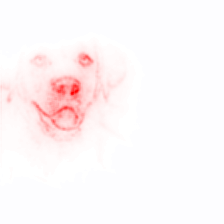

In [87]:
# conditions = [{'features.40': [117],'features.37':[5], 'y': [208]}]
conditions = [{'features.40': [19], 'features.37':[64], 'y': [208]}]

heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True)

In [88]:
rel_c[0][0]

tensor(109)

In [89]:
rel_c

[tensor([109, 274, 511,  76, 494])]

[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [274], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [511], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [76], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [494], 'y': [208]}]


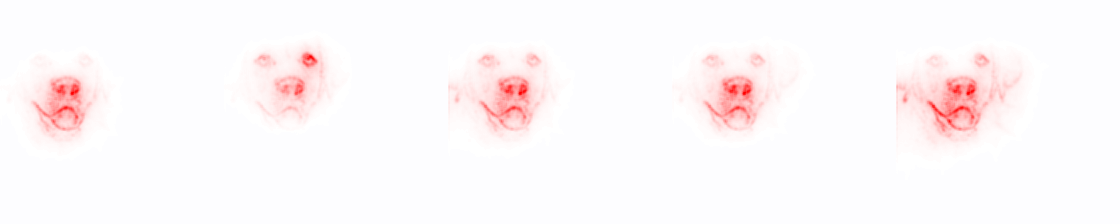

In [90]:
conditions = [{'features.40': [19],'features.37':[64],'features.34':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [91]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_34.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [92]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os


# Generate conditions and compute heatmaps
conditions = [{'features.40': [19], 'features.37': [64], 'features.34': [rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

# Define a function to add text below an image
def add_text_below_image(image, text, font_size=20, color=(0, 0, 0)):
    # Create a new image with space for the text below
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    new_img_height = image.height + text_height + 10  # 10 pixels padding
    new_image = Image.new("RGB", (image.width, new_img_height), (255, 255, 255))
    new_image.paste(image, (0, 0))
    
    text_position = ((image.width - text_width) // 2, image.height + 5)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, text, font=font, fill=color)
    
    return new_image

# Convert the heatmap to images with text below
heatmap_images = []
for j in range(len(rel_c[0])):
    img = imgify(heatmap[j], symmetric=True)  # Assuming imgify returns a PIL image for each heatmap
    text = f"f.40-> C.19,\n f.37-> C.64,\n f.34-> C.{rel_c[0][j]}"
    img_with_text = add_text_below_image(img, text)
    heatmap_images.append(img_with_text)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    # Assuming images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
# grid_size = (1, len(rel_c[0]))  # 1 row, number of columns based on len(rel_c[0])
grid_size = (len(rel_c[0]),1)  # 1 row, number of columns based on len(rel_c[0])

final_image = create_image_grid(heatmap_images, grid_size)

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_34_text.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [274], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [511], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [76], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [494], 'y': [208]}]


# layer 30

### 'features.40': [19], 'features.37':[64], 'features.34':[109] is specified to select top 5 relevant channels in direct child layer to detect nose

In [93]:
rel_c

[tensor([109, 274, 511,  76, 494])]

In [94]:
rel_c = []
conditions = [{'features.40': [19], 'features.37':[64],'features.34':[109], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.30"])
rel_c_channel = cc.attribute(attr.relevances["features.30"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])

In [95]:
rel_c

[tensor([ 74,  71, 195, 214, 102])]

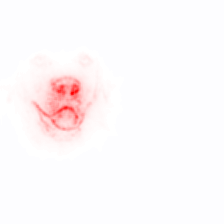

In [96]:
conditions = [{'features.40': [19], 'features.37':[64],'features.34':[109], 'y': [208]}]
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True)

[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [74], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [195], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [214], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [102], 'y': [208]}]


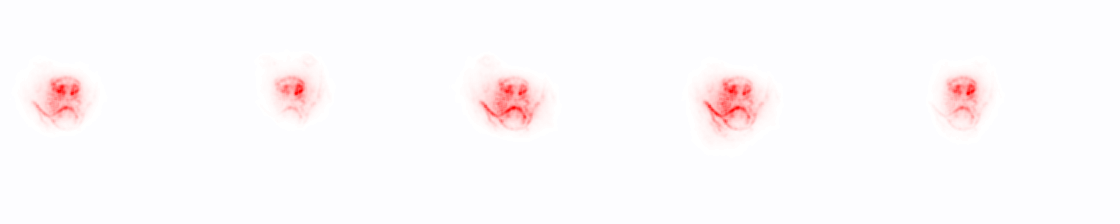

In [97]:
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [98]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_30.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [99]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os


# Generate conditions and compute heatmaps
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]

print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

# Define a function to add text below an image
def add_text_below_image(image, text, font_size=20, color=(0, 0, 0)):
    # Create a new image with space for the text below
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    new_img_height = image.height + text_height + 10  # 10 pixels padding
    new_image = Image.new("RGB", (image.width, new_img_height), (255, 255, 255))
    new_image.paste(image, (0, 0))
    
    text_position = ((image.width - text_width) // 2, image.height + 5)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, text, font=font, fill=color)
    
    return new_image

# Convert the heatmap to images with text below
heatmap_images = []
for j in range(len(rel_c[0])):
    img = imgify(heatmap[j], symmetric=True)  # Assuming imgify returns a PIL image for each heatmap
    text = f"f.40-> C.19,\n f.37-> C.64,\n f.34-> C.109,\n f.30-> C.{rel_c[0][j]}"
    img_with_text = add_text_below_image(img, text)
    heatmap_images.append(img_with_text)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    # Assuming images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
# grid_size = (1, len(rel_c[0]))  # 1 row, number of columns based on len(rel_c[0])
grid_size = (len(rel_c[0]),1)  # 1 row, number of columns based on len(rel_c[0])

final_image = create_image_grid(heatmap_images, grid_size)

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_30_text.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [74], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [195], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [214], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [102], 'y': [208]}]


In [100]:
rel_c[0][1]

tensor(71)

# layer 27

[tensor([307, 208, 135,  48, 132])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [307], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [135], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [48], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [132], 'y': [208]}]


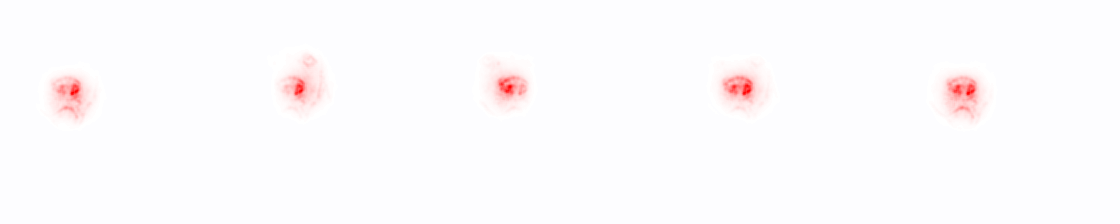

In [101]:
rel_c = []
conditions = [{'features.40': [19], 'features.37':[64],'features.34':[109], 'features.30':[71], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.27"])
rel_c_channel = cc.attribute(attr.relevances["features.27"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [102]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_27.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [103]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os


# Generate conditions and compute heatmaps
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]

print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

# Define a function to add text below an image
def add_text_below_image(image, text, font_size=20, color=(0, 0, 0)):
    # Create a new image with space for the text below
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    new_img_height = image.height + text_height + 10  # 10 pixels padding
    new_image = Image.new("RGB", (image.width, new_img_height), (255, 255, 255))
    new_image.paste(image, (0, 0))
    
    text_position = ((image.width - text_width) // 2, image.height + 5)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, text, font=font, fill=color)
    
    return new_image

# Convert the heatmap to images with text below
heatmap_images = []
for j in range(len(rel_c[0])):
    img = imgify(heatmap[j], symmetric=True)  # Assuming imgify returns a PIL image for each heatmap
    text = f"f.40-> C.19,\n f.37-> C.64,\n f.34-> C.109,\n f.30-> C.71,\n f.->27 C.{rel_c[0][j]}"
    img_with_text = add_text_below_image(img, text)
    heatmap_images.append(img_with_text)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    # Assuming images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
# grid_size = (1, len(rel_c[0]))  # 1 row, number of columns based on len(rel_c[0])
grid_size = (len(rel_c[0]),1)  # 1 row, number of columns based on len(rel_c[0])

final_image = create_image_grid(heatmap_images, grid_size)

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_27_text.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [307], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [135], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [48], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [132], 'y': [208]}]


In [104]:
rel_c[0][1]

tensor(208)

# layer 24

In [105]:
rel_c

[tensor([307, 208, 135,  48, 132])]

[tensor([119, 149, 414, 370, 259])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [149], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [414], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [370], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [259], 'y': [208]}]


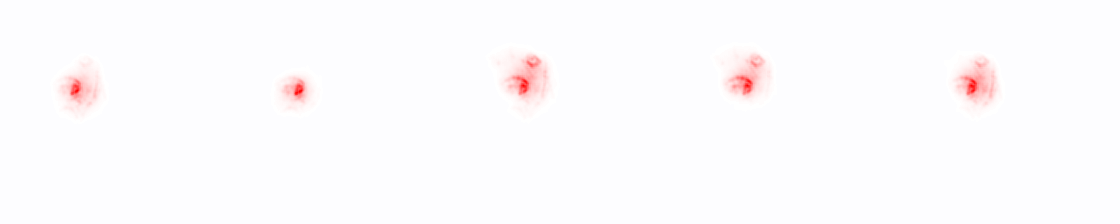

In [111]:
rel_c = []
conditions = [{'features.40': [19], 'features.37':[64],'features.34':[109], 'features.30':[71],'features.27':[208], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.24"])
rel_c_channel = cc.attribute(attr.relevances["features.24"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [112]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_24.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [113]:
import torch
from crp.attribution import CondAttribution
from crp.image import imgify
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import os


# Generate conditions and compute heatmaps
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]

print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

# Define a function to add text below an image
def add_text_below_image(image, text, font_size=20, color=(0, 0, 0)):
    # Create a new image with space for the text below
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    new_img_height = image.height + text_height + 10  # 10 pixels padding
    new_image = Image.new("RGB", (image.width, new_img_height), (255, 255, 255))
    new_image.paste(image, (0, 0))
    
    text_position = ((image.width - text_width) // 2, image.height + 5)
    draw = ImageDraw.Draw(new_image)
    draw.text(text_position, text, font=font, fill=color)
    
    return new_image

# Convert the heatmap to images with text below
heatmap_images = []
for j in range(len(rel_c[0])):
    img = imgify(heatmap[j], symmetric=True)  # Assuming imgify returns a PIL image for each heatmap
    text = f"f.40-> C.19,\n f.37-> C.64,\n f.34-> C.109,\n f.30-> C.71,\n f.27-> C.208,\n f.->24 C.{rel_c[0][j]}"
    img_with_text = add_text_below_image(img, text)
    heatmap_images.append(img_with_text)

# Create a grid image from the list of images
def create_image_grid(images, grid_size):
    """Create a grid of images."""
    # Assuming images are PIL Images and have the same size
    widths, heights = zip(*(i.size for i in images))
    
    max_width = max(widths)
    max_height = max(heights)
    
    grid_width = grid_size[0] * max_width
    grid_height = grid_size[1] * max_height
    
    new_image = Image.new('RGB', (grid_width, grid_height))
    
    x_offset = 0
    y_offset = 0
    
    for i, img in enumerate(images):
        new_image.paste(img, (x_offset, y_offset))
        x_offset += max_width
        if (i + 1) % grid_size[0] == 0:
            x_offset = 0
            y_offset += max_height
            
    return new_image

# Determine grid size
# grid_size = (1, len(rel_c[0]))  # 1 row, number of columns based on len(rel_c[0])
grid_size = (len(rel_c[0]),1)  # 1 row, number of columns based on len(rel_c[0])

final_image = create_image_grid(heatmap_images, grid_size)

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_24_text.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()


[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [149], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [414], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [370], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [259], 'y': [208]}]


In [114]:
rel_c[0][0]

tensor(119)

In [66]:
# layer_names

# layer 20

[tensor([235,  88, 108, 232, 222])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [88], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [108], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [232], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [222], 'y': [208]}]


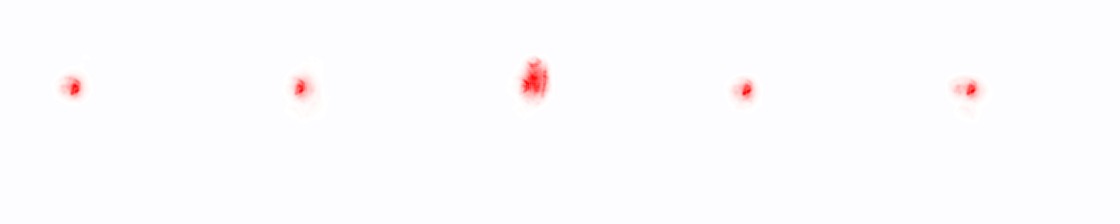

In [115]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119], 'y': [208]}]

attr = attribution(sample, conditions, composite, record_layer=["features.20"])
rel_c_channel = cc.attribute(attr.relevances["features.20"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19], 'features.37':[64],'features.34':[109], 'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [116]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_20.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [117]:
rel_c

[tensor([235,  88, 108, 232, 222])]

In [118]:
rel_c[0]

tensor([235,  88, 108, 232, 222])

# layer 17

[tensor([136, 198,  11, 100, 140])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [136], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [198], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [11], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [100], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'y': [208]}]


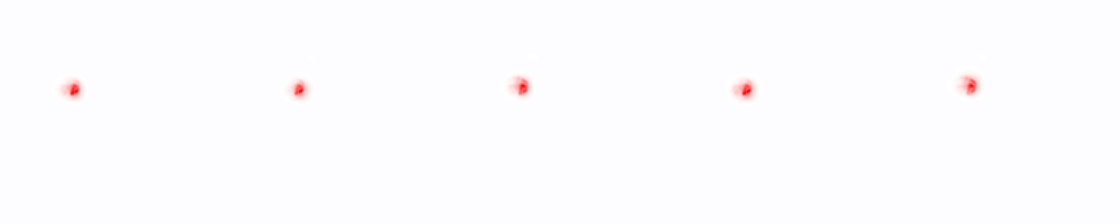

In [119]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.17"])
rel_c_channel = cc.attribute(attr.relevances["features.17"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235],'features.17':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [120]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_17.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [121]:
rel_c[0][1]

tensor(198)

# layer 14

In [122]:
rel_c

[tensor([136, 198,  11, 100, 140])]

[tensor([ 19,  36, 172, 182, 146])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [36], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [172], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [182], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119],

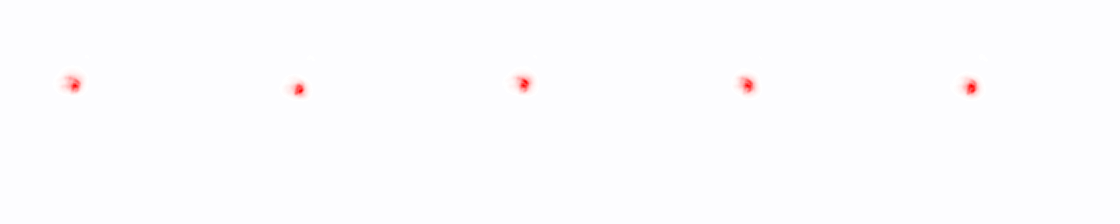

In [123]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.14"])
rel_c_channel = cc.attribute(attr.relevances["features.14"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140], 'features.14':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [124]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_14.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [125]:
rel_c[0][1]


tensor(36)

In [126]:
# layer_names

# layer 10

In [127]:
rel_c

[tensor([ 19,  36, 172, 182, 146])]

[tensor([ 43,  96,  54, 107,  78])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [96], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [54], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [107], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'fe

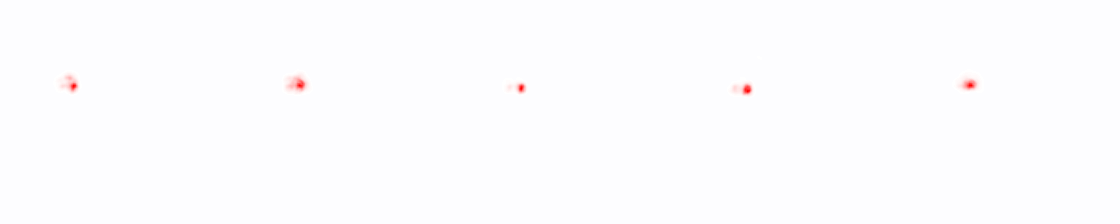

In [128]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19], 'y': [208]}]

attr = attribution(sample, conditions, composite, record_layer=["features.10"])
rel_c_channel = cc.attribute(attr.relevances["features.10"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19], 'features.10':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [129]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_10.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [130]:
rel_c[0][1]


tensor(96)

# layer 7

In [131]:
rel_c

[tensor([ 43,  96,  54, 107,  78])]

[tensor([ 67,  97,  23, 114,   0])]
[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [97], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [23], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 

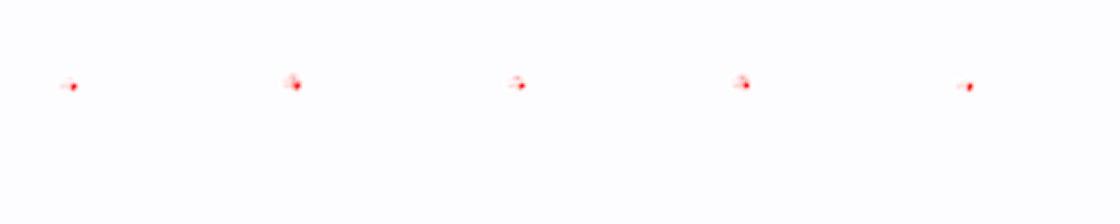

In [132]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19],'features.10':[43], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.7"])
rel_c_channel = cc.attribute(attr.relevances["features.7"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)


conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19], 'features.10':[43],'features.7':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [133]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_7.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [134]:
rel_c[0][1]


tensor(97)

# layer 3

In [135]:
rel_c

[tensor([ 67,  97,  23, 114,   0])]

In [136]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19],'features.10':[43],'features.7':[67], 'y': [208]}]

# conditions = [{'features.40': [117], 'features.37':[414],'features.34':[160], 'features.30':[91],'features.27':[33],'features.24':[5],'features.20':[235],'features.17':[140],'features.14':[192],'features.10':[51],'features.7':[127], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.3"])
rel_c_channel = cc.attribute(attr.relevances["features.3"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)




[tensor([39, 13, 32,  5, 16])]


[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [39], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [13], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [32], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19

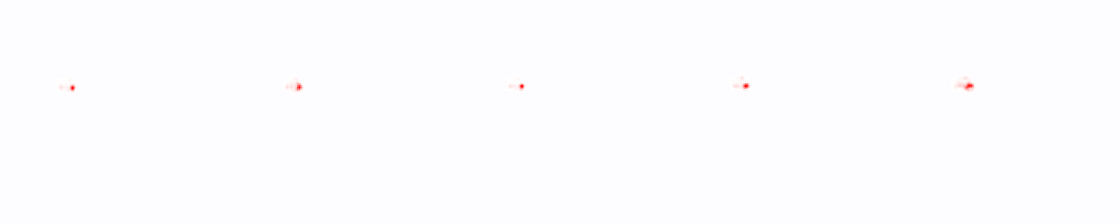

In [137]:
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19],'features.10':[43],'features.7':[67],'features.3':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [138]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_3.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [139]:
rel_c[0][3]


tensor(5)

# layer 0

In [140]:
rel_c

[tensor([39, 13, 32,  5, 16])]

In [141]:
rel_c = []
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19],'features.10':[43],'features.7':[67],'features.3':[39],  'y': [208]}]

# conditions = [{'features.40': [117], 'features.37':[414],'features.34':[160], 'features.30':[91],'features.27':[33],'features.24':[5],'features.20':[235],'features.17':[140],'features.14':[192],'features.10':[51],'features.7':[127],'features.3':[56], 'y': [208]}]
attr = attribution(sample, conditions, composite, record_layer=["features.0"])
rel_c_channel = cc.attribute(attr.relevances["features.0"], abs_norm=True)

rel_c.append(torch.argsort(rel_c_channel, descending=True)[0, :5])
print(rel_c)



[tensor([33, 12, 15, 16, 28])]


[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [39], 'features.0': [33], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [39], 'features.0': [12], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [39], 'features.0': [15], 'y': [208]}, {'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'f

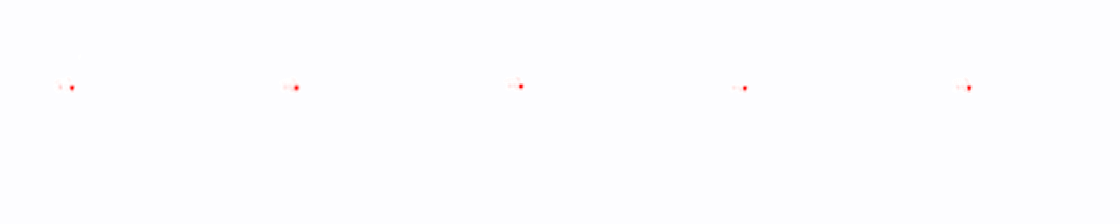

In [142]:

conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19],'features.10':[43],'features.7':[67],'features.3':[39], 'features.0':[rel_c[0][j].item()], 'y': [208]} for j in range(len(rel_c[0]))]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

In [143]:
# Create the final image
final_image = imgify(heatmap, symmetric=True, grid=(1, len(rel_c[0])))

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "heatmap_grid_0.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

In [144]:
rel_c[0][1]

tensor(12)

# Final 



In [146]:
rel_c[0]

tensor([33, 12, 15, 16, 28])

In [147]:

rel_c_0_list = rel_c[0].tolist()
print(rel_c_0_list)


[33, 12, 15, 16, 28]


In [148]:
conditions = [{'features.40': [19],'features.37':[64],'features.34':[109],'features.30':[71],'features.27':[208],'features.24':[119],'features.20':[235], 'features.17':[140],'features.14':[19],'features.10':[43],'features.7':[67],'features.3':[39], 'features.0':rel_c_0_list, 'y': [208]}]
print(conditions)
heatmap, _, _, _ = attribution(sample, conditions, composite)

# imgify(heatmap, symmetric=True)

[{'features.40': [19], 'features.37': [64], 'features.34': [109], 'features.30': [71], 'features.27': [208], 'features.24': [119], 'features.20': [235], 'features.17': [140], 'features.14': [19], 'features.10': [43], 'features.7': [67], 'features.3': [39], 'features.0': [33, 12, 15, 16, 28], 'y': [208]}]


In [149]:
# Create the final image
final_image = imgify(heatmap, symmetric=True)

# Convert to 'RGB' mode if necessary
if final_image.mode != 'RGB':
    final_image = final_image.convert('RGB')

# Specify the path and filename
save_directory = "C:/Users/praba/Desktop/z_img"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

file_name = "Final_image_heatmap_grid_dog_12.jpg"
file_path = os.path.join(save_directory, file_name)

# Save the image as a JPG file
final_image.save(file_path, format="JPEG")

# Display the resulting image
final_image.show()

### 4.1 Attribution Graph

In [150]:
layer_names

['features.0',
 'features.3',
 'features.7',
 'features.10',
 'features.14',
 'features.17',
 'features.20',
 'features.24',
 'features.27',
 'features.30',
 'features.34',
 'features.37',
 'features.40',
 'classifier.0',
 'classifier.3',
 'classifier.6']

In [151]:
from crp.graph import trace_model_graph

graph = trace_model_graph(model, sample, layer_names)
print(graph)

__module.features/__module.features.0 -> __module.features/__module.features.1, 
__module.features/__module.features.1 -> __module.features/__module.features.2, 
__module.features/__module.features.2 -> __module.features/__module.features.3, 
__module.features/__module.features.3 -> __module.features/__module.features.4, 
__module.features/__module.features.4 -> __module.features/__module.features.5, 
__module.features/__module.features.5 -> __module.features/__module.features.6, 
__module.features/__module.features.6 -> __module.features/__module.features.7, 
__module.features/__module.features.7 -> __module.features/__module.features.8, 
__module.features/__module.features.8 -> __module.features/__module.features.9, 
__module.features/__module.features.9 -> __module.features/__module.features.10, 
__module.features/__module.features.10 -> __module.features/__module.features.11, 
__module.features/__module.features.11 -> __module.features/__module.features.12, 
__module.features/__mod